# Algoritmo para Inferir red booleana

*Para inferir la red booleana se creara un funcion que reciba como parametros la funcion de busqueda, la funcion criterio y la matriz de expresion genica*

## Importacion de Librerias

In [20]:
import numpy as np
from typing import Callable, List, Tuple
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
import os
from collections import Counter
from math import log2

## Tipo de Funciones para inferir una red booleana

### Funciones de Busqueda y Evaluacion

### funcion(es) de busqueda

In [21]:
# --- Funciones de Búsqueda (Ejemplos) ---

def busqueda_exhaustiva(target_gene_index: int, matriz_expresion: np.ndarray, funcion_criterio: Callable) -> List[int]:
    """
    Busca exhaustivamente los mejores predictores para un gen objetivo, considerando subconjuntos de 1, 2 y 3 genes.

    Args:
        target_gene_index (int): El índice del gen objetivo.
        matriz_expresion (np.ndarray): La matriz de expresión génica.
        funcion_criterio (Callable): La función de criterio para evaluar los predictores.

    Returns:
        List[int]: Una lista con los índices de los mejores predictores encontrados.
    """
    print(f"\nSearching predictors for target gene {target_gene_index}")
    num_genes = matriz_expresion.shape[1]
    mejor_predictores = []
    mejor_criterio = float('inf')  # Inicializamos con un valor alto

    # Iterar sobre los subconjuntos de predictores de tamaño 1, 2 y 3
    for size in range(1, min(4, num_genes)):
      for predictores_indices in _combinations_no_repetir(list(range(num_genes)), size, target_gene_index):
        
        criterio = funcion_criterio(matriz_expresion, target_gene_index, predictores_indices)

        if criterio < mejor_criterio:
            mejor_criterio = criterio
            mejor_predictores = predictores_indices
    for size in range(1, min(4, num_genes)):
        print(f"\nTesting predictor sets of size {size}")
        # ...rest of loop code...

    return mejor_predictores

def _combinations_no_repetir(lista: List, n: int, target_gene_index: int) -> List:
    """
    Genera combinaciones de n elementos de una lista, excluyendo un índice específico.
    """
    if n==1:
        for i in lista:
            if i != target_gene_index:
                yield [i]
        return

    for i in range(len(lista)):
        if lista[i] != target_gene_index:
           for sub_comb in _combinations_no_repetir(lista[i+1:], n - 1, target_gene_index):
              yield [lista[i]]+sub_comb



### funcion(es) de penalizacion

In [22]:
# --- Funciones de Criterio (Ejemplos) ---

def error_absoluto(matriz_expresion: np.ndarray, target_gene_index: int, predictores_indices: List[int]) -> float:
    """
    Calcula el error absoluto promedio entre la expresión del gen objetivo y la predicción booleana basada en los predictores.
    
    Args:
        matriz_expresion (np.ndarray): La matriz de expresión génica.
        target_gene_index (int): El índice del gen objetivo.
        predictores_indices (List[int]): La lista de índices de los genes predictores.

    Returns:
        float: El error absoluto promedio.
    """
    target_gene = matriz_expresion[:, target_gene_index]
    num_condiciones = len(target_gene)

    if not predictores_indices:
        # En el caso de que no existan predictores devolvemos un valor alto
        return float('inf')

    predicciones = np.zeros(num_condiciones)
    for condicion in range(num_condiciones):
        valores_predictores = [matriz_expresion[condicion, i] for i in predictores_indices] 

        # Implementacion del OR
        prediccion = 0
        if any([True if value > 0 else False for value in valores_predictores]):
          prediccion = 1

        predicciones[condicion] = prediccion


    return np.mean(np.abs(target_gene - predicciones))
def _calcular_entropia(p: float) -> float:
    """Calcula la entropía para una probabilidad dada."""
    if p == 0 or p == 1:
        return 0
    return -p * log2(p) - (1 - p) * log2(1 - p)

def _calcular_entropia_gen(gen: np.ndarray) -> float:
    """Calcula la entropía para un gen dado."""
    num_condiciones = len(gen)
    p = np.sum(gen) / num_condiciones
    return _calcular_entropia(p)

def informacion_mutua_condicional(matriz_expresion: np.ndarray, target_gene_index: int, predictores_indices: List[int]) -> float:
    """
    Calcula la información mutua condicionada entre el gen objetivo y los predictores.
    Esta implementacion considera el OR como funcion booleana.

    Args:
        matriz_expresion (np.ndarray): La matriz de expresión génica.
        target_gene_index (int): El índice del gen objetivo.
        predictores_indices (List[int]): La lista de índices de los genes predictores.

    Returns:
        float: La información mutua condicionada.
    """
    target_gene = matriz_expresion[:, target_gene_index]
    num_condiciones = len(target_gene)

    if not predictores_indices:
         # En el caso de que no existan predictores devolvemos un valor bajo
        return float('-inf')
    
    entropia_target = _calcular_entropia_gen(target_gene)
    
    # Calcular la entropía condicional
    entropia_condicional = 0
    for predictores_estado in [0, 1]:
        indices = []
        for condicion in range(num_condiciones):
            valores_predictores = [matriz_expresion[condicion, i] for i in predictores_indices] 
            
            # Implementacion del OR
            prediccion = 0
            if any([True if value > 0 else False for value in valores_predictores]):
               prediccion = 1
            
            if prediccion == predictores_estado:
                indices.append(condicion)
                
        if len(indices) > 0:
            entropia_condicional += (len(indices) / num_condiciones) * _calcular_entropia_gen(target_gene[indices])
    
    return entropia_target - entropia_condicional


### Funciones de Lectura

In [23]:
# --- Funciones de Lectura de Archivo ---

def leer_matriz_deg(archivo_path: str) -> np.ndarray:
    """
   Lee una matriz de expresión de un archivo .deg, donde la primera línea tiene el número de tiempos y el número de genes

    Args:
      archivo_path: La ruta al archivo .deg.

    Returns:
        np.ndarray: La matriz de expresión como un array NumPy.
    """

    if not os.path.exists(archivo_path):
        raise FileNotFoundError(f"El archivo '{archivo_path}' no fue encontrado.")

    try:
        with open(archivo_path, "r") as file:
          lineas = file.readlines()
          if not lineas:
            raise ValueError("El archivo esta vacio.")
          
          header = lineas[0].strip().split()
          if len(header) != 2:
              raise ValueError("La primera línea debe tener dos valores (número de tiempos y número de genes).")
          try:
              num_tiempos = int(header[0])
              num_genes = int(header[1])
          except ValueError:
              raise ValueError("Los valores en la primera línea deben ser números enteros.")

          if num_tiempos <= 0 or num_genes <= 0:
                raise ValueError("Los valores de número de tiempos y número de genes deben ser mayores a 0.")

          matriz = []
          for linea in lineas[1:]:
             linea = linea.strip().split()
             try:
               fila = [int(x) for x in linea]
               if len(fila) != num_genes:
                    raise ValueError(f"La fila {linea} tiene un número incorrecto de columnas.")
               matriz.append(fila)
             except ValueError:
                raise ValueError(f"Error en la conversión de datos en la línea: '{linea}'. Asegúrese de que todos los valores sean enteros.")

          if len(matriz) != num_tiempos:
              raise ValueError(f"El número de filas {len(matriz)} no coincide con el número de instantes de tiempo {num_tiempos}.")
          return np.array(matriz)
    except Exception as e:
       raise Exception(f"Error al leer el archivo {archivo_path}: {e}")



def leer_red_ylu(archivo_path: str, num_genes: int) -> dict:
    """
    Lee la red desde archivo .ylu con validación de índices.
    """
    red = {}
    try:
        with open(archivo_path, "r") as file:
            lines = file.readlines()
            for line in lines:
                if not line.strip() or line.startswith('RANDOM') or line.startswith('NN'):
                    continue
                    
                if '|' in line:
                    parts = line.strip().split('|')
                    if len(parts) >= 2:
                        predictors = parts[0].strip().split(',')
                        target = parts[1].strip()
                        
                        try:
                            target_gene = int(target)
                            # Validar índice del gen objetivo
                            if target_gene >= num_genes:
                                continue
                                
                            predictor_genes = []
                            for p in predictors:
                                if p.strip().isdigit():
                                    pred = int(p)
                                    # Validar índice del predictor
                                    if pred < num_genes:
                                        predictor_genes.append(pred)
                            red[target_gene] = predictor_genes
                        except ValueError:
                            continue
                            
    except Exception as e:
        raise Exception(f"Error al leer el archivo {archivo_path}: {e}")
        
    return red



## Clase para inferir una red booleana

In [31]:


class InferirRedBooleana:
    def __init__(self, funcion_busqueda: Callable, funcion_criterio: Callable, matriz_expresion: np.ndarray):
        """
        Inicializa la clase InferirRedBooleana.

        Args:
            funcion_busqueda (Callable): Una función que busca los mejores predictores.
            funcion_criterio (Callable): Una función que evalúa la calidad de un conjunto de predictores.
            matriz_expresion (np.ndarray): La matriz de expresión génica (genes x condiciones).
        """
        self.funcion_busqueda = funcion_busqueda
        self.funcion_criterio = funcion_criterio
        self.matriz_expresion = matriz_expresion
        self.num_genes = matriz_expresion.shape[1]
        self.red = {}  # Diccionario para almacenar la red inferida: {gen: [predictores]}

    def inferir_red(self) -> dict:
        """
        Infiere la red de regulación génica utilizando las funciones proporcionadas.

        Returns:
            dict: Un diccionario que representa la red inferida (gen: lista_de_predictores).
        """
        for target_gene_index in range(self.num_genes):
            predictores = self.funcion_busqueda(target_gene_index, self.matriz_expresion, self.funcion_criterio)
            self.red[target_gene_index] = predictores
        return self.red

    def obtener_red(self) -> dict:
        """
        Retorna la red inferida.

        Returns:
            dict:  Un diccionario que representa la red inferida (gen: lista_de_predictores).
        """
        return self.red
    
    def generar_matriz_confusion_con_etiquetas(self, red_verdadera: dict, target_names: List[str]) -> None:
      self.funcion_evaluacion.generar_matriz_confusion_con_etiquetas(self.red, red_verdadera, target_names)
    
    def evaluar_precision(self, red_verdadera: dict) -> float:
        return self.funcion_evaluacion.evaluar_precision(self.red,red_verdadera)

    

## Salidas

In [29]:
def guardar_red_inferida(red_inferida: dict, funcion_busqueda: str, funcion_criterio: str) -> None:
    """
    Guarda la red inferida en un archivo JSON.
    
    Args:
        red_inferida (dict): Red inferida
        nombre_archivo (str, optional): Nombre personalizado del archivo
    """
    import os
    import json
    from datetime import datetime
    
    # Crear directorio si no existe
    directorio = 'redes_inferidas'
    if not os.path.exists(directorio):
        os.makedirs(directorio)
        
    # Generar ID único con timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Crear nombre de archivo con formato específico
    nombre_archivo = f'red_inferida_{funcion_busqueda}_{funcion_criterio}_{timestamp}.json'
    ruta_archivo = os.path.join(directorio, nombre_archivo)
    
    # Preparar datos para guardar
    datos = {
        'metadata': {
            'id': timestamp,
            'funcion_busqueda': funcion_busqueda,
            'funcion_criterio': funcion_criterio,
            'fecha_creacion': datetime.now().isoformat()
        },
        'red_inferida': red_inferida
    }
    
    # Guardar en formato JSON
    with open(ruta_archivo, 'w') as f:
        json.dump(datos, f, indent=4)
        
    print(f"\nRed inferida guardada en: {ruta_archivo}")




## Ejemplo de Uso


Searching predictors for target gene 0

Testing predictor sets of size 1

Testing predictor sets of size 2

Testing predictor sets of size 3

Searching predictors for target gene 1

Testing predictor sets of size 1

Testing predictor sets of size 2

Testing predictor sets of size 3

Searching predictors for target gene 2

Testing predictor sets of size 1

Testing predictor sets of size 2

Testing predictor sets of size 3

Searching predictors for target gene 3

Testing predictor sets of size 1

Testing predictor sets of size 2

Testing predictor sets of size 3

Searching predictors for target gene 4

Testing predictor sets of size 1

Testing predictor sets of size 2

Testing predictor sets of size 3

Searching predictors for target gene 5

Testing predictor sets of size 1

Testing predictor sets of size 2

Testing predictor sets of size 3

Searching predictors for target gene 6

Testing predictor sets of size 1

Testing predictor sets of size 2

Testing predictor sets of size 3

Searc

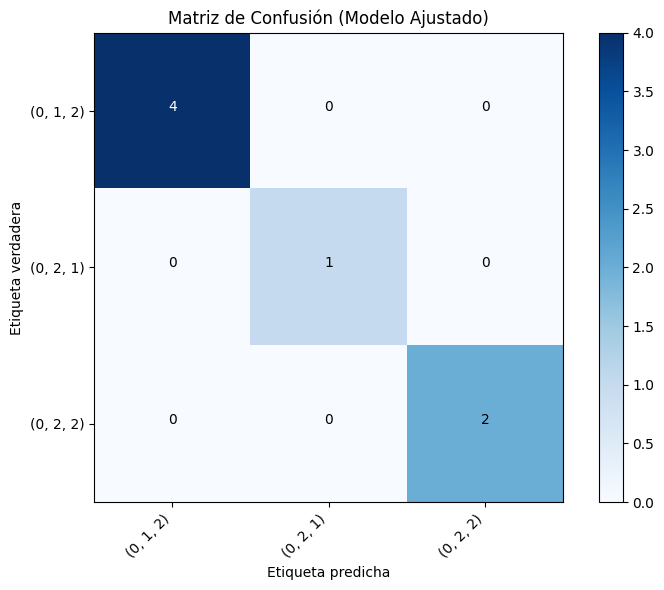

In [30]:
# --- Ejemplo de uso ---

# Modificar código principal:
if __name__ == '__main__':
    try:
        # Leer matriz de expresión
        matriz_exp = leer_matriz_deg("expresion_genica.deg")
        num_genes = matriz_exp.shape[1]
        
        # Leer red verdadera con límite de genes
        red_verdadera = leer_red_ylu("network_gene.ylu", num_genes)
        
        # Crear instancia y inferir red
        red_inferencia = InferirRedBooleana(busqueda_exhaustiva, informacion_mutua_condicional, matriz_exp)
        red_inferida = red_inferencia.inferir_red()
        
        # Guardar red antes de generar matriz
        guardar_red_inferida(
            red_inferida=red_inferida,
            funcion_busqueda="busqueda_exhaustiva",
            funcion_criterio="error_absoluto"
        )
        print("\nRed inferida guardada exitosamente")
        
        # Generar matriz de confusión
        target_names = [f'Gen {i}' for i in range(num_genes)]
        red_inferencia.generar_matriz_confusion_con_etiquetas(red_verdadera, target_names)
        
    except Exception as e:
        print(f"Se produjo un error inesperado: {e}")
 